# Music Classification

*By Ali Lotfollahi*

## Importing Necessary Libraries

In [1]:
from typing import *
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import os
import hmmlearn 

## Parameters

In [42]:
# data
DATA_LOCATION = "data"
TRAIN_RATIO = 0.9
N_HIDDEN_STATE_VALUES = 5

# audio processing
SAMPLE_RATE = 22050
SAMPLE_SIZE = SAMPLE_RATE * 14
N_MFCC = 13
FRAME_SIZE = 1024
HOP_SIZE = 512
N_DERIVATIVES = 3
N_ITERATIONS = 1

# example
EXAMPLE = {
    "genre": "hiphop",
    "index": 0
}

In [3]:
frame_duration = FRAME_SIZE / SAMPLE_RATE
frame_duration

0.046439909297052155

In [4]:
sample_duration = SAMPLE_SIZE / SAMPLE_RATE
sample_duration

14.0

## Vectorized Needed Functions

In [5]:
path_join = np.vectorize(os.path.join)
librosa_mfcc = np.vectorize(librosa.feature.mfcc, signature="(n,m)->(n,l,k)", excluded=["sr", "n_mfcc", "n_fft", "hop_length"])
librosa_delta = np.vectorize(librosa.feature.delta, signature="(n,l,k)->(n,l,k)", excluded=["order"])
# multivariate_normal_pdf = np.vectorize(multivariate_normal.pdf, signature="(k)->()", excluded=["mean", "cov"])

## Plotting Functions

In [6]:
def waveshow(y: np.ndarray, sr: float, ax: plt.Axes):
    librosa.display.waveshow(y, 
            sr=sr,
            color="b",
            alpha=0.5,
            ax=ax)
    ax.set_xlim(0, y.size / sr)

In [7]:
def specshow(data: np.ndarray, sr: float, x_axis: str, ax: plt.Axes, *args, **kwargs):
    img = librosa.display.specshow(data,
        x_axis=x_axis, 
        sr=SAMPLE_RATE,
        ax=ax,
        *args, **kwargs)
    plt.colorbar(img, ax=ax)

## Getting the Data

### Genres

In [8]:
genres = os.listdir(DATA_LOCATION)
n_genres = len(genres)
genres

['pop', 'hiphop', 'blues', 'metal']

### Audio File Paths

In [9]:
audio_files = {}
for genre in genres:
    genre_files = os.listdir(os.path.join(DATA_LOCATION, genre))
    genre_file_paths = path_join(DATA_LOCATION, genre, genre_files)
    audio_files.update({genre: genre_file_paths})

### Audio Contents

In [10]:
audio_samples = {}
for genre in genres:    
    genre_audio_samples = [librosa.load(file_path, sr=SAMPLE_RATE)[0] 
            for file_path in audio_files[genre]]
                
    audio_samples.update({genre: genre_audio_samples})

#### Breaking Audio Content into Samples with the Same Size

In [11]:
for genre in genres:    
    genre_audio_samples = audio_samples[genre]
    new_genre_audio_samples = []
    for s in genre_audio_samples:
        start = (s.size % SAMPLE_SIZE) // 2
        for k in range(start, s.size - SAMPLE_SIZE, SAMPLE_SIZE):
            new_genre_audio_samples.append(s[k:k + SAMPLE_SIZE])
    new_genre_audio_samples = np.array(new_genre_audio_samples)
                
    audio_samples.update({genre: new_genre_audio_samples})

In [12]:
for genre in genres:
    print(audio_samples[genre].shape)

(200, 308700)
(200, 308700)
(200, 308700)
(200, 308700)


### Mel-Frequency Cepstral Coefficients($MFCCs$)

In [13]:
mfccs = {}
for genre in genres:
    genre_mfccs = librosa_mfcc(y=audio_samples[genre], 
                sr=SAMPLE_RATE, 
                n_mfcc=N_MFCC,
                n_fft=FRAME_SIZE,
                hop_length=HOP_SIZE)

    mfccs.update({genre: genre_mfccs})

In [14]:
for genre in genres:
    print(mfccs[genre].shape)

(200, 13, 603)
(200, 13, 603)
(200, 13, 603)
(200, 13, 603)


### $\Delta MFCCs$

In [15]:
delta_mfccs = {}
for genre in genres:
    genre_delta_mfccs = librosa_delta(mfccs[genre])
    
    delta_mfccs.update({genre: genre_delta_mfccs})

In [16]:
for genre in genres:
    print(delta_mfccs[genre].shape)

(200, 13, 603)
(200, 13, 603)
(200, 13, 603)
(200, 13, 603)


### $\Delta\Delta MFCCs$

In [17]:
delta2_mfccs = {}
for genre in genres:
    genre_delta2_mfccs = librosa_delta(mfccs[genre], order=2)
    
    delta2_mfccs.update({genre: genre_delta2_mfccs})

In [18]:
for genre in genres:
    print(delta2_mfccs[genre].shape)

(200, 13, 603)
(200, 13, 603)
(200, 13, 603)
(200, 13, 603)


### Encapsulating All Observations

In [19]:
obs = {}
for genre in genres:
    genre_obs = np.concatenate([mfccs[genre], delta_mfccs[genre], delta2_mfccs[genre]], axis=1)
    
    obs.update({genre: genre_obs})

In [20]:
for genre in genres:
    print(obs[genre].shape)

(200, 39, 603)
(200, 39, 603)
(200, 39, 603)
(200, 39, 603)


### Forming Train and Test Observations

In [21]:
train_obs = {}
test_obs = {}
for genre in genres:
    genre_obs = obs[genre]
    n_genre_obs = genre_obs.shape[0]
    n_train_obs = int(TRAIN_RATIO * n_genre_obs)
    train_obs.update({genre: genre_obs[:n_train_obs]})
    test_obs.update({genre: genre_obs[n_train_obs:]})

## Visualization

In [40]:
def show_spec(data: np.ndarray, ax: plt.Axes):
    specshow(data=data, 
             sr=SAMPLE_RATE, 
             x_axis="time", 
             ax=ax,
             n_fft=FRAME_SIZE, 
             hop_length=HOP_SIZE)
    ax.set_xlabel("Quefrencies")
    ax.set_xlim(0, sample_duration)
    ax.set_yticks(np.arange(N_MFCC))
    ax.set_yticklabels(np.arange(N_MFCC) + 1)

An Example of Pop:


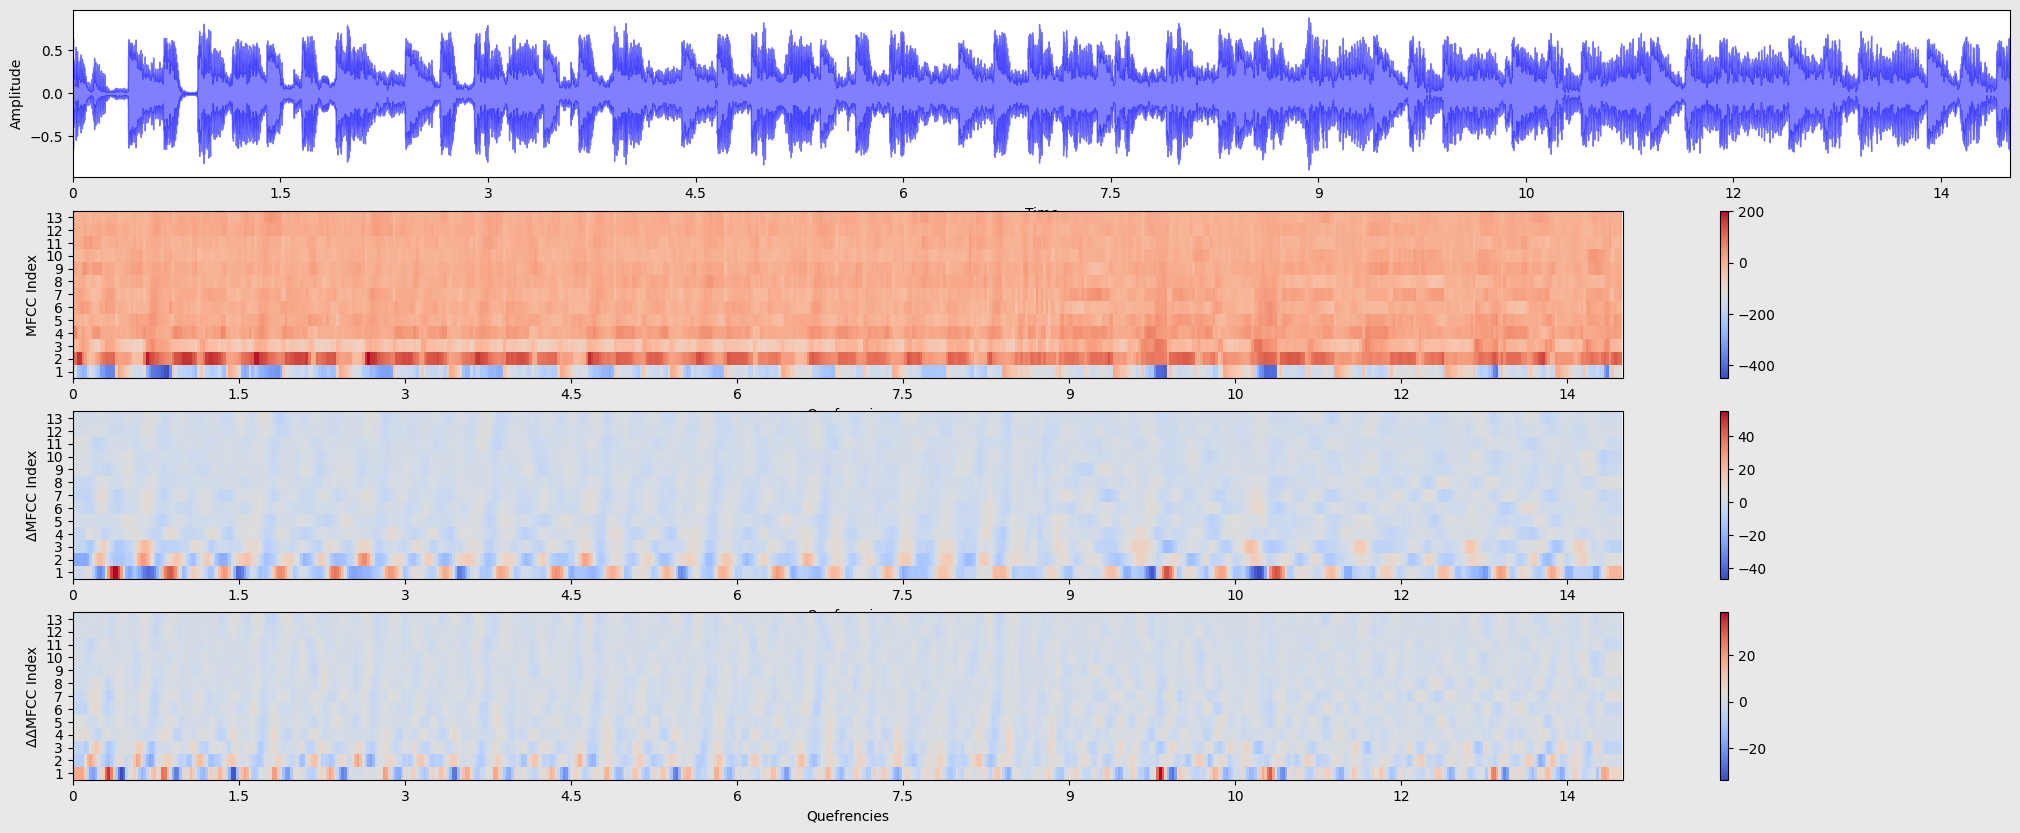

An Example of Hiphop:


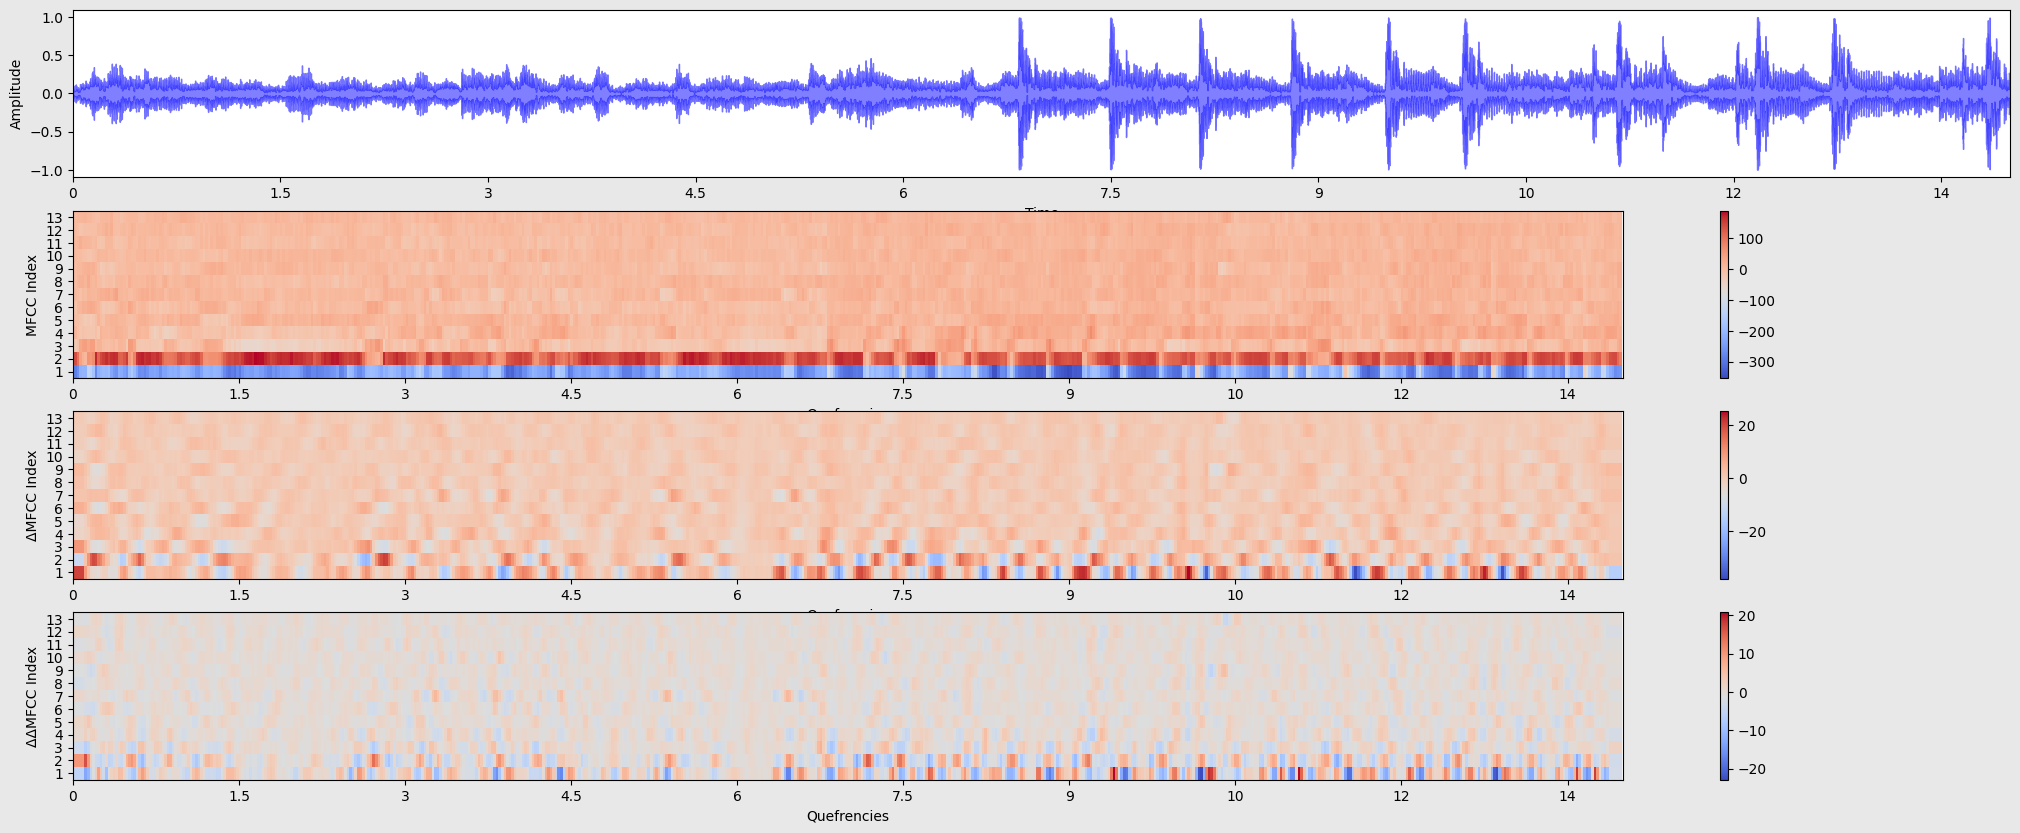

An Example of Blues:


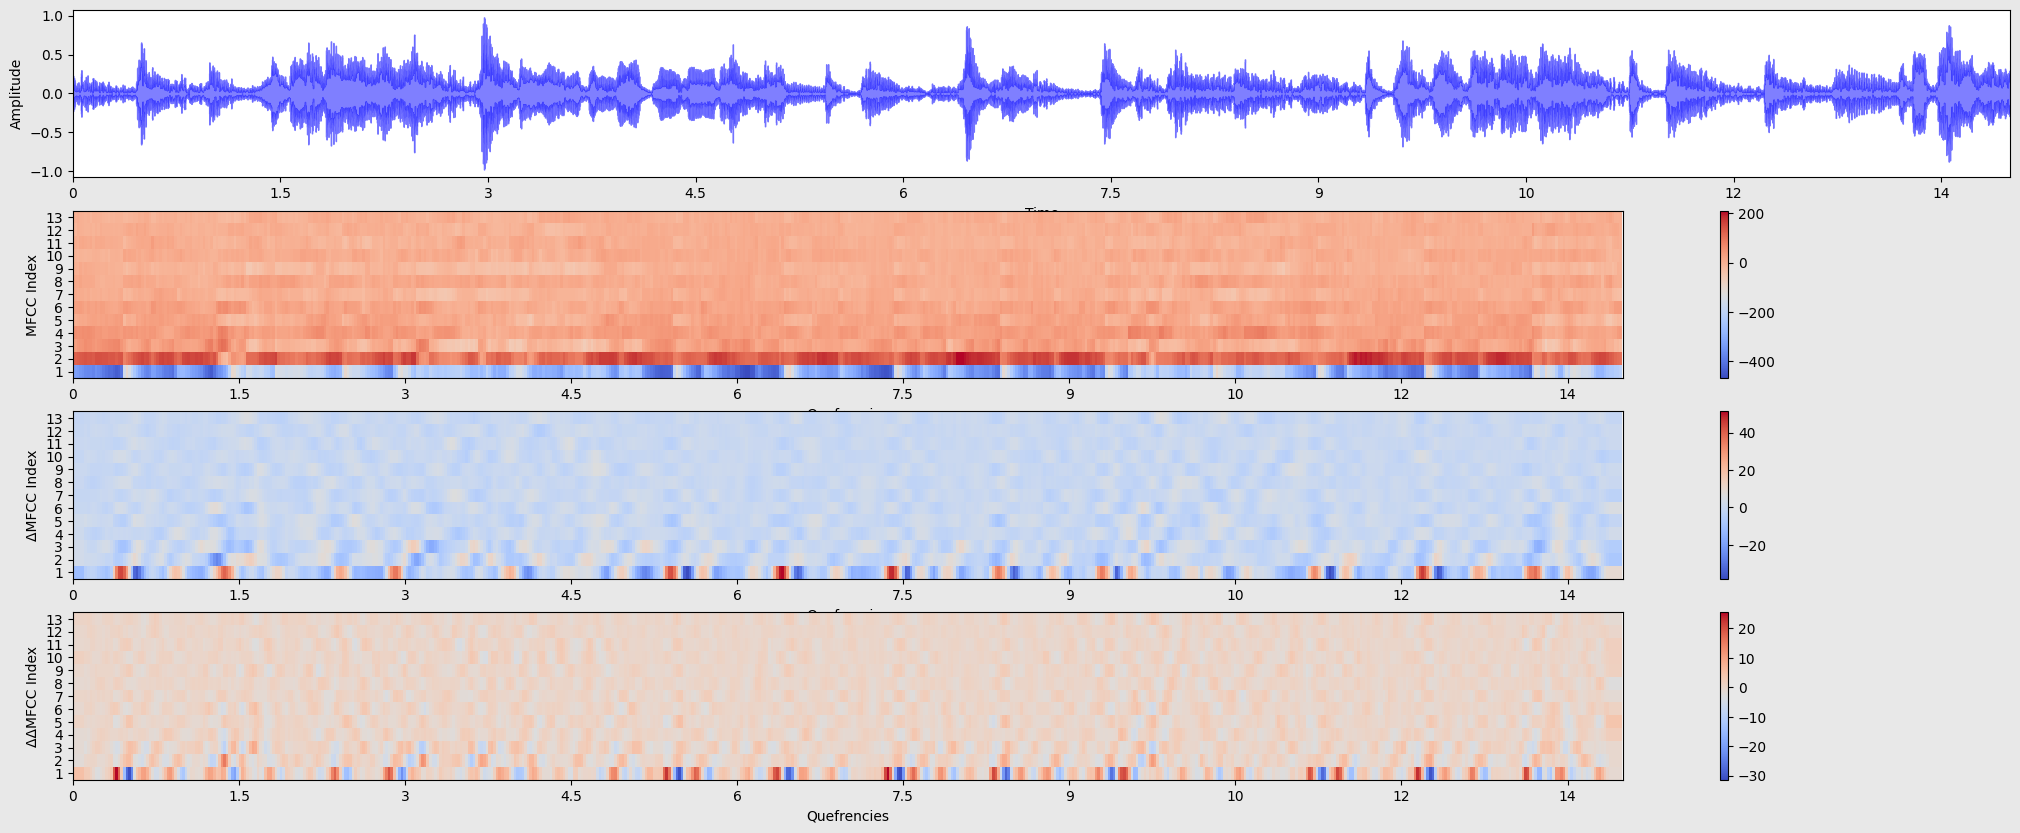

An Example of Metal:


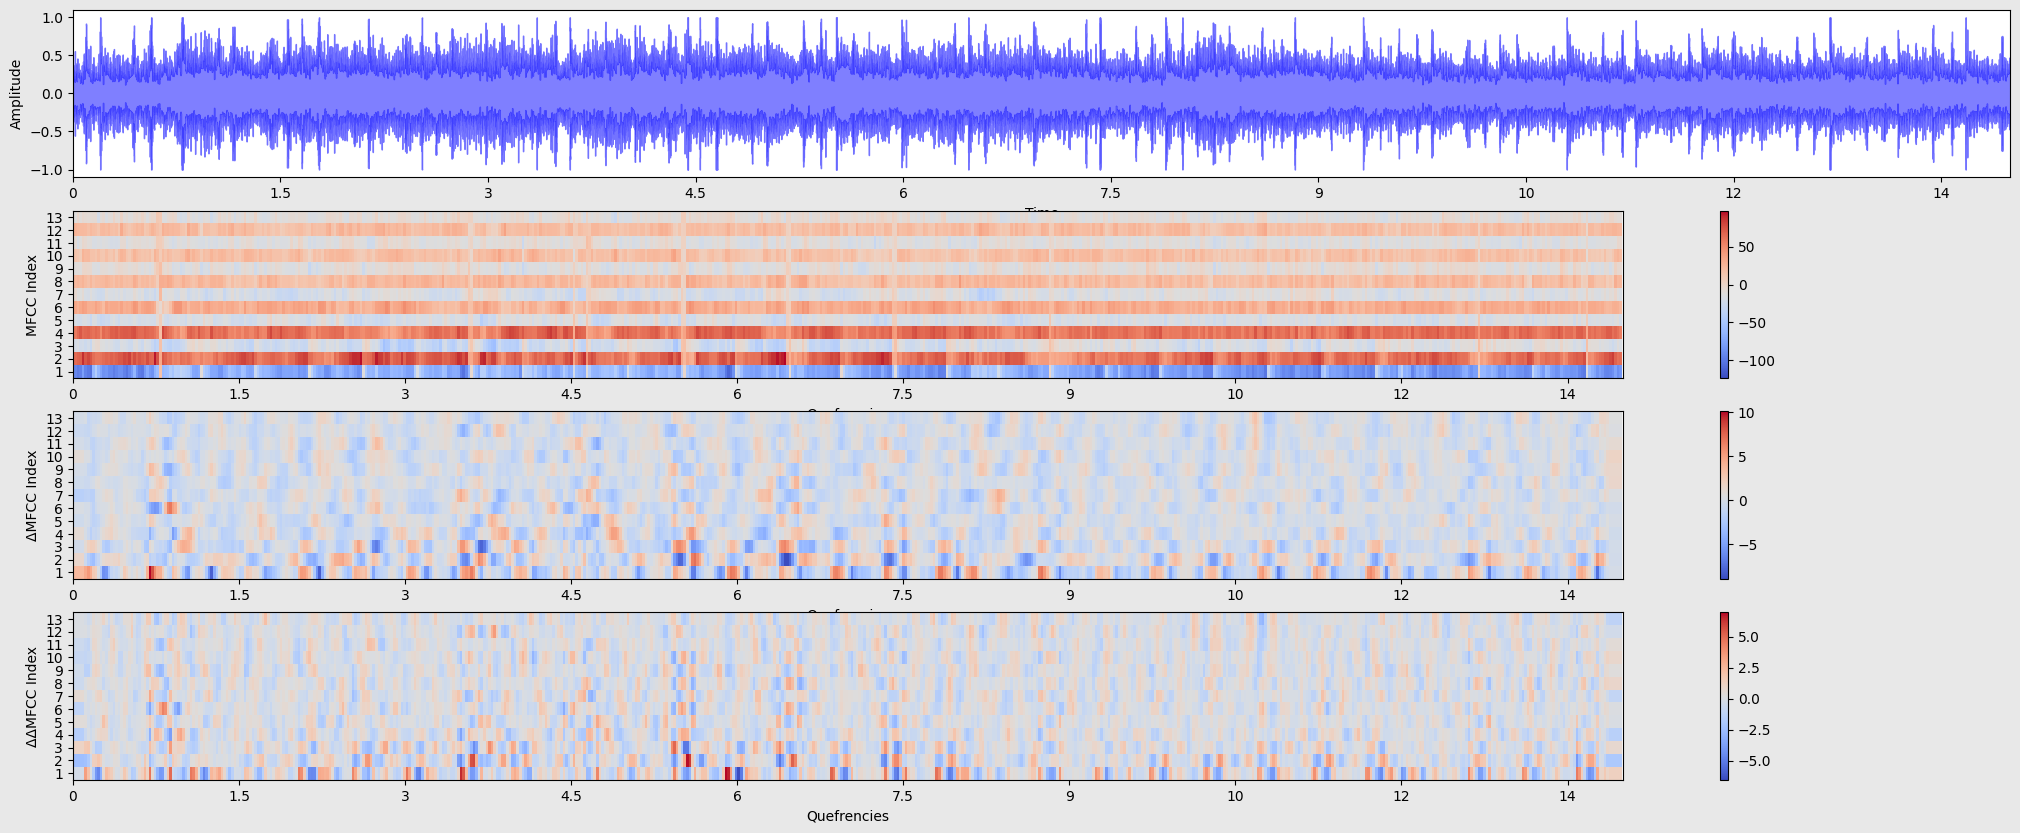

In [41]:
index = EXAMPLE["index"]
for i, genre in enumerate(genres):
    print(f"An Example of {genre.capitalize()}:")
    ipd.display(ipd.Audio(audio_files[genre][index]))
    fig, axes = plt.subplots(4, 1)
    fig.set_size_inches(25, 10)
    fig.patch.set_facecolor((.7, .7, .7, 0.3))
    
    
    # plotting amplitude
    ax = axes[0]
    data = audio_samples[genre][index]
    waveshow(y= data, 
            sr=SAMPLE_RATE, 
            ax=ax)
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time")
    
    # plotting mfccs
    ax = axes[1]
    data = mfccs[genre][index]
    
    show_spec(data=data, ax=ax)
    ax.set_ylabel("MFCC Index")
    
    # plotting delta mfccs
    ax = axes[2]
    data = delta_mfccs[genre][index]
    
    show_spec(data=data, ax=ax)
    ax.set_ylabel("\u0394MFCC Index")
    
    # plotting delta2 mfccs
    ax = axes[3]
    data = delta2_mfccs[genre][index]
    
    show_spec(data=data, ax=ax)
    ax.set_ylabel("\u0394\u0394MFCC Index")
    
    plt.show()

## Questions Related to Pre-processing

### 1. Why do we need frames with the same length?

In order to compute Mel-frequency cepstral coefficients we need to first decide the length of each frame. Because if MFCCs were not computed with a single definite frame length, they would not give any comparability.  
In order to explain this better the procedure of MFCC computation is given below when given the signal $x(t)$:
1. First, for each frame $x_f(n)$, discrete fourier transform of the signal should be calculated. $$ \hat{x}(f) = \hat{x}(\frac{k}{NT}) = \hat{x}(\frac{ks_r}{N}) = \sum_{n = 0}^{N-1} x_f(n)w(n) e^{-i2\pi\frac{k}{N}n} $$ where $N$ is the size of each frame, $T$ is the period, and $s_r$ is the sample rate of the signal. $w(n)$ is the windowing function that is applied to frames.
2. Then, the frequencies should be turned into Mel-scale.
3. Next, the magnitude of each Mel-scaled frequency should be turned into decibels that is a logarithmic scale.
4. At last, an inverse fourier transform should be taken to turn the frequency axis back to a psudo-time one that is referred to as **quefrencies**.

### 2. Why frames should have overlaps?

The reason is windowing function. By windowing each frame, different portions of it will get mathematically emphasized differently. In order to nullify this incident, the approach taken is having overlapping frames.

### 3. Why in most projects only 12 or 13 MFCC indices re taken into the account?

The answer is the fact that as much as the indices grow, their information will be more about noises than they will be a piece of valuable information. This is one advantage of MFCCs. They accumulate almost all the essential information first few indices.

## Modeling the Genre Classification Task as a Hidden Markov Model

## Questions Regarding Hidden Markov Models and How They Are Applied to This Case

### 1. What are *states* and *observations* in an HMM?

**States** are literally the state that each sample is at, at each time. States are represented as $ST = \{S_1, S_2, \dots, S_n\}$. In this case, $n$ is determined by `num_hidden_states` in the initialization of each HMM. The state at time $t$ is represented as $q_t \in ST$.

**Observations** are the events experienced by an exterior observer that are caused by the state that the sample is in at the time. They are shown as $OB = \{O_1, O_2, \dots, O_m\}$ which in this case $OB = \R^{N_{derivatives} \times N_{MFCCs}}$. The observation seen at the time $t$ is designated as $o_t \in OB$.

### 2. What is a first-order HMM?

All HMMs are defined with three kinds of tables:
1. prior: for each $i$: $P(q_0 = S_i)$,
2. transition model: for each $i$ and $t$:  $P(q_t = S_{it} | q_{t-1} = S_{i(t-1)}, \dots, q_0 = S_{i0})$,
3. emission model: for each $i$, $j$: $P(o_t = O_j | q_t = S_i)$.

In first-order HMMs, transition model is described with only $P(q_t = S_{i_1} | q_{t-1} = S_{i_0})$, which means that $q_t$ is conditionally independent of all $q_{t'}$, where $t' \lt t - 1$, given $q_{t-1}$.

### 3. For what kinds of problems, HMMs are used?

HMMs provide a realistic model for when sequentially connected observations are perceived but the causes of those observations are unclear so they should be classified. In other words, HMMs are good when there exists an underlying finite state machine that emits those observations.

### 4. What are advantages and disadvantages of HMMs?

**Advantages:**
1. strong statistical foundation
2. learning can happen by Baum-Welch algorithm over raw data
3. allow consistent treatment of insertion and deletion penalties

**Disadvantages:**
1. HMMs often have large numbers of unstructured parameters
2. first-order HMMs are limited by their first-order markov property
3. They can not express dependencies among hidden states (*important*)

### 5. What kinds of HMMs exists?



### `HiddenMarkovModel` Class

Transition Model

$$ t_{ij} = P(q_t = S_j | q_{t-1} = S_i)

In [32]:
class HiddenMarkovModel:
    def __init__(self: Self, num_hidden_states: int):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob: np.ndarray = self._normalize(self.rand_state.rand(self.num_hidden_states))
        self.transition_matrix: np.ndarray = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None
        

    def _forward(self: Self, B: np.ndarray):
        """
            alpha
            
            Parameters
            -
                B: ndarray(n_hidden_states, T)

            Returns
            -
                ndarray(n_hidden_states, T), float
        """
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)

        for t in range(T):
            if t == 0:
                alpha[:, 0] = self.initial_prob * B[:, 0]
                
            else:
                _product = alpha[:, t - 1, None] * self.transition_matrix
                alpha[:, t] = np.sum(_product, axis=0)
                alpha[:, t] *= B[:, t]
            
            alpha_sum = np.sum(alpha[:, t])
            log_likelihood += -np.inf if alpha_sum == 0 else np.log(alpha_sum)
            alpha_sum += (alpha_sum == 0)
            alpha[:, t] /= alpha_sum

        return alpha, log_likelihood

    def _backward(self: Self, B: np.ndarray):
        """
            beta
            
            Parameters
            -
                B: ndarray(n_hidden_states, T)

            Returns
            -
                ndarray(n_hidden_states, T)
        """
        T = B.shape[1]
        beta = np.ones(B.shape)
        
        beta[:, -1] /= np.sum(beta[:, -1])
        for t in range(T - 1)[::-1]:
            _product = self.transition_matrix * beta[:, t + 1] * B[:, t + 1]
            beta[:, t] = np.sum(_product, axis=1)
            
            beta_sum = np.sum(beta[:, t])
            beta_sum += (beta_sum == 0)
            beta[:, t] /= beta_sum

        return beta

    def _state_likelihood(self: Self, obs: np.ndarray): 
        """
            the sensor model
            
            Parameters
            -
                obs: ndarray(n_dimensions, n_frames)

            Returns
            -
                ndarray(n_hidden_states, n_frames)
        """
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))
            
        obs_transpose = np.transpose(obs)
        
        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs_transpose, 
                    mean=self.mean[:, s], 
                    cov=self.covariances[:, :, s],
                    allow_singular=True)
            
        B = np.where(np.isinf(B), 1.7976931348623157e+308, B)
            
        return B

    def _normalize(self, x):
        try:
            min_x = np.min(x[x != 0])
        except:
            min_x = 1
        new_x = x + (x == 0) * min_x
        return new_x / np.sum(new_x)

    def _stochasticize(self, x):
        try:
            min_x = np.min(x[x != 0])
        except:
            min_x = 1
        new_x = x + (x == 0) * min_x
        return new_x / np.sum(new_x, axis=1)[:, None]

    def _em_init(self: Self, obs: np.ndarray):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.var(obs, axis=1))[:, :, None]

        return self

    def _em_step(self: Self, obs: np.ndarray):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)
        alpha, _ = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            xi_sum += alpha[:, t, None] * self.transition_matrix * beta[:, t + 1] * B[:, t + 1]
            
            gamma[:, t] = self._normalize(alpha[:, t] * beta[:, t])
        gamma[:, -1] = self._normalize(alpha[:, -1] * beta[:, -1])
        
        hidden_states = np.argmax(gamma, axis=0)
        
        expected_prior = gamma[:, 0]
        expected_transition = self._stochasticize(xi_sum)

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum += (gamma_state_sum == 0)
        
        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            # gamma_obs = obs * gamma[s, :]
            
            gamma_obs = obs * gamma[s, :] * (hidden_states == s)
            
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
        
        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.transition_matrix = expected_transition

    def train(self: Self, obs: np.ndarray, num_iterations:int=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        
        return self

    def score(self: Self, obs: np.ndarray):
        B = self._state_likelihood(obs)
        _, log_likelihood = self._forward(B)
        return log_likelihood


## Training

In [33]:
def compute_covariances(train_obs: np.ndarray):
    # print(train_obs.shape)
    covariances = np.zeros((N_DERIVATIVES * N_MFCC, N_DERIVATIVES * N_MFCC, N_HIDDEN_STATE_VALUES))
    covariances += np.diag(np.var( \
        train_obs, axis=1))[:, :, None]
    return covariances

In [34]:
def compute_covariances_alt(train_obs: np.ndarray):
    covariances = np.zeros((N_DERIVATIVES * N_MFCC, N_DERIVATIVES * N_MFCC, N_HIDDEN_STATE_VALUES))
    cov = np.cov(train_obs)
    covariances += cov[:, :, None]
    return covariances

In [35]:
train_obs_all = np.concatenate([train_obs[genre] for genre in genres])
train_obs_all_cov = train_obs_all[:, :N_DERIVATIVES * N_MFCC, :].transpose(1, 0, 2).reshape(N_DERIVATIVES * N_MFCC, -1)
covariances_all = compute_covariances_alt(train_obs_all_cov)

In [36]:
hmm_models = {}
for genre in genres:
    print(f"training an HMM for '{genre}'")
    genre_hmm_model = HiddenMarkovModel(N_HIDDEN_STATE_VALUES)
    genre_train_obs: np.ndarray = train_obs[genre]

    genre_train_obs_cov = genre_train_obs[:, :N_DERIVATIVES * N_MFCC, :].transpose(1, 0, 2).reshape(N_DERIVATIVES * N_MFCC, -1)
    # genre_hmm_model.covariances = compute_covariances(genre_train_obs_cov)
    genre_hmm_model.covariances = compute_covariances_alt(genre_train_obs_cov)
    # genre_hmm_model.covariances = covariances_all
    
    for o in genre_train_obs:
        genre_hmm_model.train(obs=o[:N_DERIVATIVES * N_MFCC], num_iterations=N_ITERATIONS)
    
    hmm_models.update({genre: genre_hmm_model})


training an HMM for 'pop'


training an HMM for 'hiphop'
training an HMM for 'blues'
training an HMM for 'metal'


In [37]:
for genre in genres:
    genre_hmm_model = hmm_models[genre]
    print(f"\ngenre={genre}: genre_hmm_transition_model=\n{genre_hmm_model.transition_matrix}")


genre=pop: genre_hmm_transition_model=
[[7.71673092e-132 1.33878992e-120 1.33878992e-120 1.33878992e-120
  1.00000000e+000]
 [1.42088449e-169 1.44779789e-149 2.46511877e-158 5.91178728e-143
  1.00000000e+000]
 [7.67509425e-151 1.33156629e-139 1.33156629e-139 1.33156629e-139
  1.00000000e+000]
 [4.77496101e-156 8.28416814e-145 8.28416814e-145 8.28416814e-145
  1.00000000e+000]
 [5.90260469e-283 1.45173840e-262 2.66153812e-281 4.31993562e-276
  1.00000000e+000]]

genre=hiphop: genre_hmm_transition_model=
[[9.27617647e-114 2.00652519e-215 2.00652519e-215 1.00000000e+000
  2.00652519e-215]
 [7.59176143e-001 1.03193871e-098 1.03193871e-098 2.40823857e-001
  1.03193871e-098]
 [7.59176143e-001 1.03193871e-098 1.03193871e-098 2.40823857e-001
  1.03193871e-098]
 [2.73697477e-278 6.56197270e-280 6.56197270e-280 1.00000000e+000
  6.56197270e-280]
 [7.59176143e-001 1.03193871e-098 1.03193871e-098 2.40823857e-001
  1.03193871e-098]]

genre=blues: genre_hmm_transition_model=
[[1.00000000e+000 3.298

In [38]:
try:
    n_wrong, n_total = 0, 0
    for genre in genres:
        genre_train_obs = train_obs[genre]
        # print(f"tests for {genre}")
        for o in genre_train_obs:
            scores = [hmm_models[genre1].score(o[:N_DERIVATIVES * N_MFCC]) for genre1 in genres]
            best_match = np.argmax(scores)
            # print(f"scores = {scores}")
            if genre != genres[best_match]:
                n_wrong += 1
                # print(f"failed (genre={genres[best_match]})")
            else:
                # print("passed")
                pass
            n_total += 1
finally:
    print(f"{n_wrong} wrong answers out of {n_total}")
    print(f"error ratio: {n_wrong / n_total}")

117 wrong answers out of 720
error ratio: 0.1625


## Testing

In [39]:
try:
    n_wrong, n_total = 0, 0
    for genre in genres:
        genre_test_obs = test_obs[genre]
        # print(f"tests for {genre}")
        for o in genre_test_obs:
            scores = [hmm_models[genre1].score(o[:N_DERIVATIVES * N_MFCC]) for genre1 in genres]
            best_match = np.argmax(scores)
            # print(f"scores = {scores}")
            if genre != genres[best_match]:
                n_wrong += 1
                # print(f"failed (genre={genres[best_match]})")
            else:
                # print("passed")
                pass
            n_total += 1
finally:
    print(f"{n_wrong} wrong answers out of {n_total}")
    print(f"error ratio: {n_wrong / n_total}")

17 wrong answers out of 80
error ratio: 0.2125
